### Mount G Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup Project





In [2]:
# Upload and unzip project code

from google.colab import files
import os
import sys

# Upload the zip file
if not os.path.exists('/content/fineTune.zip'):
  uploaded = files.upload()
  zip_name = list(uploaded.keys())[0]
else:
  zip_name = '/content/fineTune.zip'
  print("FineTune.zip already exists")

# Unzip into the main content directory
!unzip -q {zip_name}

# IMPORTANT: Add your project's root directory to the Python path
# Add your project's root directory to Python's search path
project_root = '/content/fineTune'
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"✅ Added '{project_root}' to Python's path.")

Saving fineTune.zip to fineTune.zip
✅ Added '/content/fineTune' to Python's path.


In [3]:
cwd = %pwd
print(f'Current Working Directory: {cwd}')

Current Working Directory: /content


In [4]:
# %rm -r /content/fineTune

### Install Dependencies

In [5]:
# Install all required packages

%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2


!pip install -q -r /content/fineTune/colab_requirements.txt

%%capture
!pip install "timm==1.0.19"   # Only for Gemma 3N
!pip install "gdown==5.2.0"

import unsloth
# print(unsloth.__version__)
import torch; torch._dynamo.config.recompile_limit = 64;

### GPU | Memory

In [6]:
from utils import get_gpu_status, get_gpu_usage_stats
get_gpu_status()

      System Hardware & Memory Status

--- RAM Status ---
Total System RAM: 167.05 GiB
Note: You are using a high-RAM runtime!

--- GPU Status ---

--- nvidia-smi Report ---
Sun Sep 21 12:52:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             55W /  400W |       5MiB /  

In [7]:
from utils import capture_key_dependency_versions
capture_key_dependency_versions()

   Capturing Key Dependency Versions for Reproducibility
✅ Found: torch==2.8.0+cu126
✅ Found: transformers==4.55.4
✅ Found: trl==0.22.2
✅ Found: peft==0.17.1
✅ Found: accelerate==1.10.1
✅ Found: bitsandbytes==0.47.0
✅ Found: datasets==4.0.0
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/lib/python3.12/importlib/__init__.py:90: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  return _bootstrap._gcd_import(name[level:], package, level)


🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Found: unsloth==2025.9.7
✅ Found: timm==1.0.19
✅ Found: xformers==0.0.32.post2
✅ Found: pandas==2.2.2
✅ Found: yaml==6.0.2
✅ Found: triton==3.4.0
✅ Found: cut_cross_entropy==25.1.1
✅ Found: unsloth_zoo==2025.9.9
✅ Found: hf_transfer==0.1.9
✅ Found: huggingface_hub==0.34.4
✅ Found: sentencepiece==0.2.1
❌ Error: Package 'protobuf' is not installed.

--- Frozen Requirements ---
Copy the text block below and paste it into your requirements.txt file.
---------------------------
accelerate==1.10.1
bitsandbytes==0.47.0
cut_cross_entropy==25.1.1
datasets==4.0.0
hf_transfer==0.1.9
huggingface_hub==0.34.4
pandas==2.2.2
peft==0.17.1
sentencepiece==0.2.1
timm==1.0.19
torch==2.8.0+cu126
transformers==4.55.4
triton==3.4.0
trl==0.22.2
unsloth==2025.9.7
unsloth_zoo==2025.9.9
xformers==0.0.32.post2
yaml==6.0.2
---------------------------


### Setup *Hugging Face*

In [8]:
# Log in to Hugging Face

from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

print(f"HF Token: {hf_token[-5:]}")

HF Token: Hjpyu


### Modify *'configs.yaml'* for Google Colab

In [9]:
# Modify config paths for a hybrid Colab + Drive environment

import yaml
import os

CONFIG_FILE_PATH = '/content/fineTune/configs/configs.yaml'

# --- DEFINE STORAGE LOCATIONS ---
# 1. Temporary, fast storage on the Colab machine itself
COLAB_DISK_BASE_PATH = '/content/fineTune'

# 2. Permanent, persistent storage in your Google Drive
DRIVE_BASE_PATH = '/content/drive/MyDrive/FineTunning/Gemma'                  # A dedicated folder in your Drive

# Create the permanent storage directory in Google Drive if it doesn't exist
from fineTune.utils import make_clean_dir

make_clean_dir(DRIVE_BASE_PATH)
make_clean_dir(f'{DRIVE_BASE_PATH}/models')
make_clean_dir(f'{DRIVE_BASE_PATH}/logs')


with open(CONFIG_FILE_PATH, 'r') as f:
    config = yaml.safe_load(f)

# --- UPDATE PATHS IN THE CONFIG ---

# 1. DATASET PATHS: Point to the large, fast, TEMPORARY Colab disk
config['dataset']['paths']['base_dir'] = f'{COLAB_DISK_BASE_PATH}/dataset/vizWiz'
config['dataset']['paths']['temp_zip_dir'] = f'{COLAB_DISK_BASE_PATH}/dataset/vizWiz/zips'
config['dataset']['paths']['images_dir'] = f'{COLAB_DISK_BASE_PATH}/dataset/vizWiz/images'
config['dataset']['paths']['annotations_dir'] = f'{COLAB_DISK_BASE_PATH}/dataset/vizWiz/annotations'
config['dataset']['paths']['processed_dir'] = f'{COLAB_DISK_BASE_PATH}/dataset/vizWiz/processed_for_tuning'

# 2. FINE-TUNING OUTPUTS: Point to your PERMANENT Google Drive
config['fineTune']['adapters_output_dir'] = f'{DRIVE_BASE_PATH}/models/gemma-3n-adapters'
config['fineTune']['trainer_output_dir'] = f'{DRIVE_BASE_PATH}/models/training_checkpoints'
config['fineTune']['merged_model_output_dir'] = f'{DRIVE_BASE_PATH}/models/gemma-3n-merged-model'
config['fineTune']['logging_dir'] = f'{DRIVE_BASE_PATH}/logs'
config['fineTune']['dataset_path'] = f'{COLAB_DISK_BASE_PATH}/dataset/vizWiz/processed_for_tuning'

# Write the updated configuration back to the file
with open(CONFIG_FILE_PATH, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("✅ Configuration file updated for a hybrid Colab + Google Drive environment.")
print("*"* 20)
print("--- New Config ---")
print("*"* 20)
!cat {CONFIG_FILE_PATH}

✅ Configuration file updated for a hybrid Colab + Google Drive environment.
********************
--- New Config ---
********************
dataset:
  paths:
    annotations_dir: /content/fineTune/dataset/vizWiz/annotations
    base_dir: /content/fineTune/dataset/vizWiz
    images_dir: /content/fineTune/dataset/vizWiz/images
    processed_dir: /content/fineTune/dataset/vizWiz/processed_for_tuning
    temp_zip_dir: /content/fineTune/dataset/vizWiz/zips
  preparation_steps:
    check_dataset_integrity: true
    run_prepare_step: true
    run_transform_step: true
  subset:
    enabled: true
    train_percentage: 0.3
    val_percentage: 0.3
  urls:
    gdrive_urls:
      annotations: https://drive.google.com/uc?export=download&id=1tUGMdeM_CrFjDBaGKhdJ3Hacb0Bj1oAr
      test_images: https://drive.google.com/uc?export=download&id=1qiZVdJo9kAVYy7OUaPjY1Dbmh5UirEB9
      train_images: https://drive.google.com/uc?export=download&id=1iiE1svRhVUc3CYvZBi02HqqoL_kdzFf_
      val_images: https://drive.

In [10]:
pwd

'/content'

In [11]:
%ls

drive/  fineTune/  fineTune.zip  sample_data/  unsloth_compiled_cache/


## Prepare Data

In [12]:
# Run the data preparation and transformation
import prepare_data

# Run the main function from `prepare_data.py`
prepare_data.main()

🚀 =============================================== 🚀
         Fine-Tunning | Data Pipeline Runner
🚀 =============================================== 🚀

--- Running Step: Prepare Raw Dataset ---
Initializing the data pipeline...
Using Google Drive URLs for dataset download.
🚀 =============================================== 🚀
      Starting the Full VizWiz Data Pipeline
🚀 =============================================== 🚀


Downloading...
From: https://drive.google.com/uc?export=download&id=1tUGMdeM_CrFjDBaGKhdJ3Hacb0Bj1oAr
To: /content/fineTune/dataset/vizWiz/zips/uc?export=download&id=1tUGMdeM_CrFjDBaGKhdJ3Hacb0Bj1oAr
100%|██████████| 979k/979k [00:00<00:00, 82.8MB/s]



Unzipping uc?export=download&id=1tUGMdeM_CrFjDBaGKhdJ3Hacb0Bj1oAr directly to target location...


Extracting: 100%|██████████| 4/4 [00:00<00:00, 103.72it/s]


Successfully extracted to: /content/fineTune/dataset/vizWiz/annotations
------------------------------


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1iiE1svRhVUc3CYvZBi02HqqoL_kdzFf_
From (redirected): https://drive.google.com/uc?export=download&id=1iiE1svRhVUc3CYvZBi02HqqoL_kdzFf_&confirm=t&uuid=146351c3-9b62-4aa9-bdf9-4a3b224ab5bc
To: /content/fineTune/dataset/vizWiz/zips/uc?export=download&id=1iiE1svRhVUc3CYvZBi02HqqoL_kdzFf_
100%|██████████| 2.28G/2.28G [00:17<00:00, 132MB/s]



Unzipping uc?export=download&id=1iiE1svRhVUc3CYvZBi02HqqoL_kdzFf_ directly to target location...


Extracting: 100%|██████████| 4687/4687 [00:08<00:00, 560.20it/s]


Successfully extracted to: /content/fineTune/dataset/vizWiz/images/train
------------------------------


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1m6ntNW0dQP5e8mpNBEkEKo_WY4IIcW67
From (redirected): https://drive.google.com/uc?export=download&id=1m6ntNW0dQP5e8mpNBEkEKo_WY4IIcW67&confirm=t&uuid=3b50c4a6-4958-4a9a-9d19-3abd679a805c
To: /content/fineTune/dataset/vizWiz/zips/uc?export=download&id=1m6ntNW0dQP5e8mpNBEkEKo_WY4IIcW67
100%|██████████| 730M/730M [00:05<00:00, 123MB/s]



Unzipping uc?export=download&id=1m6ntNW0dQP5e8mpNBEkEKo_WY4IIcW67 directly to target location...


Extracting: 100%|██████████| 1551/1551 [00:02<00:00, 562.79it/s]


Successfully extracted to: /content/fineTune/dataset/vizWiz/images/val
------------------------------


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1qiZVdJo9kAVYy7OUaPjY1Dbmh5UirEB9
From (redirected): https://drive.google.com/uc?export=download&id=1qiZVdJo9kAVYy7OUaPjY1Dbmh5UirEB9&confirm=t&uuid=3eab8ae1-cd9a-443c-9c36-d43c24098e75
To: /content/fineTune/dataset/vizWiz/zips/uc?export=download&id=1qiZVdJo9kAVYy7OUaPjY1Dbmh5UirEB9
100%|██████████| 799M/799M [00:05<00:00, 137MB/s]



Unzipping uc?export=download&id=1qiZVdJo9kAVYy7OUaPjY1Dbmh5UirEB9 directly to target location...


Extracting: 100%|██████████| 1601/1601 [00:02<00:00, 560.65it/s]


Successfully extracted to: /content/fineTune/dataset/vizWiz/images/test
------------------------------
--- Starting Dataset Preparation (JSON to JSONL) ---
Processing train annotations...
Saved 22788 records to /content/fineTune/dataset/vizWiz/annotations/train.jsonl
Processing val annotations...
Saved 7559 records to /content/fineTune/dataset/vizWiz/annotations/val.jsonl
Processing test annotations...
Saved 1600 test records to /content/fineTune/dataset/vizWiz/annotations/test.jsonl

✅ =============================================== ✅
      Data Pipeline Completed Successfully!
      Dataset is ready at: /content/fineTune/dataset/vizWiz
✅ =============================================== ✅

✅ Step 'Prepare Raw Dataset' finished successfully.

--- Running Step: Transform Dataset for Tuning ---
--- Starting Dataset Transformation ---
Loading .jsonl files from: /content/fineTune/dataset/vizWiz/annotations


Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Original dataset loaded: DatasetDict({
    train: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 22788
    })
    val: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 7559
    })
})

--- ❗ Subset Mode is ENABLED ---
  - Subsetting 'train' split to 0.3% (68/22788 examples).
  - Subsetting 'val' split to 0.3% (22/7559 examples).

New dataset size for processing: DatasetDict({
    train: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 68
    })
    val: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 22
    })
})

Applying conversational transformation using .map()...


Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Filter:   0%|          | 0/68 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22 [00:00<?, ? examples/s]


Transformation complete. Dataset stats:
  - train: 68 -> 68 samples
  - val: 22 -> 22 samples

Saving transformed dataset to: /content/fineTune/dataset/vizWiz/processed_for_tuning


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22 [00:00<?, ? examples/s]

✅ Your model-ready dataset is now saved at: /content/fineTune/dataset/vizWiz/processed_for_tuning

✅ Step 'Transform Dataset for Tuning' finished successfully.

--- Running Step: Verify Dataset Integrity ---
--- Starting Dataset Integrity Verification ---

Verifying 'train' split...
  - Subset mode: expecting 68 examples.
  - Examples in processed 'train' set: 68
  ✅ Verification successful for this split.

Verifying 'val' split...
  - Subset mode: expecting 22 examples.
  - Examples in processed 'val' set: 22
  ✅ Verification successful for this split.

✅ Step 'Verify Dataset Integrity' finished successfully.

✅ =============================================== ✅
    Data Pipeline run has finished!
    Total execution time: 51.84 seconds
✅ =============================================== ✅


## Visualize Data

🚀 Executing Dataset Viewer...
🔄 Loading lightweight dataset from '/content/fineTune/dataset/vizWiz/processed_for_tuning'...

    Displaying FULL instance [12] from split 'train'

{'messages': [{'content': [{'image': None,
                            'text': 'You are a helpful assistant for a '
                                    'visually impaired person. Your task is to '
                                    'describe the scene in the provided image '
                                    'clearly and concisely, focusing on '
                                    'potential obstacles or key objects.',
                            'type': 'text'},
                           {'image': <PIL.Image.Image image mode=RGB size=1224x1632 at 0x7E2C8023FA40>,
                            'text': None,
                            'type': 'image'}],
               'role': 'user'},
              {'content': [{'image': None,
                            'text': "a sachet packaged of Farley' s Orange "
     

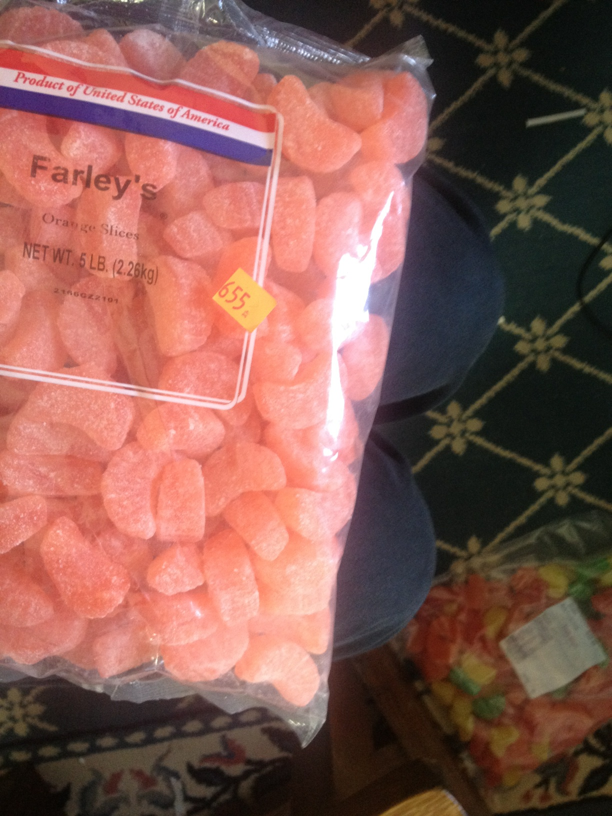



Viewer finished.


In [13]:
import visualize_data

visualize_data.VIEW_SPLIT = "train"   # The split to view ('train' or 'validation').
visualize_data.VIEW_INDEX = 12        # The index of the example to view.

# Run the main function from `visualize_data.py`
visualize_data.main()

## Train

#### Imports

In [14]:
# --- Unsloth must be imported before transformers, trl, peft ---
from unsloth import FastVisionModel  # FastLanguageModel
from unsloth.trainer import UnslothVisionDataCollator
from unsloth import get_chat_template

import os
import sys
import io
import time
from dataclasses import dataclass
from typing import Any
from PIL import Image

import torch
import torch.cuda
import yaml
from data_pipeline import load_dataset
from trl import SFTConfig, SFTTrainer

# --- Local Utilities ---
from utils import (
    DetailedLoggingCallback,
    display_evaluation_summary,
    display_training_summary,
    get_gpu_usage_stats,
    make_clean_dir,
    push_merged_model_to_hub,
    save_merged_model_locally,
    setupTensorboard,
)


#### Load Configuration

In [16]:
# --- Load Configuration ---
CONFIG_FILE_PATH = "fineTune/configs/configs.yaml"

try:
    with open(CONFIG_FILE_PATH, "r") as f:
        config = yaml.safe_load(f)
except Exception as e:
    print(f"❌ ERROR: Failed to load configuration file '{CONFIG_FILE_PATH}': {e}")
    sys.exit(1)

#### Define Constants

In [17]:
# --- Define Constants ---
MODEL_ID = config["fineTune"]["model_to_use"]
PROCESSED_DATASET_PATH = config["dataset"]["paths"]["processed_dir"]
FINAL_ADAPTERS_OUTPUT_DIR = config["fineTune"]["adapters_output_dir"]
TRAINER_OUTPUT_DIR = config["fineTune"]["trainer_output_dir"]
LOGGING_DIR = config["fineTune"]["logging_dir"]

# Assume these are defined earlier in your script
start_gpu_memory: float = 0.0
max_memory: float = 1.0

#### Prepare Directories

In [18]:
# --- Prepare Directories ---
make_clean_dir(FINAL_ADAPTERS_OUTPUT_DIR)
make_clean_dir(TRAINER_OUTPUT_DIR)
make_clean_dir(LOGGING_DIR)

#### Load Model and Processor

In [19]:
# --- Load Model and Processor ---
print(f"--- Loading model with Unsloth: {MODEL_ID} ---")
model, vision_processor = FastVisionModel.from_pretrained(
    model_name=MODEL_ID,
    load_in_4bit=True,                      # We can safely re-enable 4-bit!
    use_gradient_checkpointing="unsloth",   # True or "unsloth" for long context,
    # max_seq_length=1024,                  # You can define this here
    # dtype=torch.bfloat16,                 # Use bfloat16
    # device_map="auto",
)
print("✅ Model and processor loaded and optimized by Unsloth.")

--- Loading model with Unsloth: unsloth/gemma-3-4b-pt ---
==((====))==  Unsloth 2025.9.7: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.38G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

✅ Model and processor loaded and optimized by Unsloth.


#### Configure LoRA (PEFT Adapters) with Unsloth

In [20]:
# --- Configure LoRA (PEFT Adapters) with Unsloth ---
# Unsloth patches the model to prepare it for LoRA
model = FastVisionModel.get_peft_model(
    model=model,
    finetune_vision_layers=True,      # False if not finetuning vision layers
    finetune_language_layers=True,    # False if not finetuning language layers
    finetune_attention_modules=True,  # False if not finetuning attention layers
    finetune_mlp_modules=True,        # False if not finetuning MLP layers
    r=16,                             # The larger, the higher the accuracy, but might overfit
    lora_alpha=16,                    # Recommended alpha == r at least
    lora_dropout=0,                   # 0.05
    bias="none",
    random_state=3407,
    use_rslora=False,                 # We support rank stabilized LoRA
    loftq_config=None,                # And LoftQ
    target_modules="all-linear",      # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)
print("✅ LoRA configured.")

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients
Unsloth: Allowing gradients for `base_model.model.model.language_model.embed_tokens` since it's in `modules_to_save`.
Unsloth: Allowing gradients for `base_model.model.lm_head` since it's in `modules_to_save`.
✅ LoRA configured.


#### Load Dataset

In [21]:
# --- Load Dataset ---
dataset = load_dataset(config)

# print("\n--- Decoding images in memory for the trainer ---")
# dataset = dataset.map(decode_images, batched=False)
# print("✅ Images decoded successfully.")


--- Loading dataset from disk: /content/fineTune/dataset/vizWiz/processed_for_tuning ---

✅ Dataset loaded and ready for training:
DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 68
    })
    val: Dataset({
        features: ['messages'],
        num_rows: 22
    })
})


In [ ]:
# Inspect a sample from the dataset to understand the structure of the 'messages' field

print("--- Inspecting a sample from the training dataset ---")

# Access a sample from the training dataset
sample = dataset["train"][0]
print("\nStructure of the first sample:")
print(sample)

# Specifically look at the 'messages' field
messages = sample.get("messages")
print("\nStructure of the 'messages' field:")
print(messages)

# Inspect the content within each message, focusing on image information
print("\nContent within each message:")
for i, message in enumerate(messages):
    print(f"\nMessage {i}:")
    print(message)
    content = message.get("content")
    if content:
        for j, item in enumerate(content):
            print(f"  Item {j}:")
            print(item)
            if item.get("type") == "image":
                print("    >>> Found image information here. Checking type:")
                print(f"    >>> Type of 'image' field: {type(item.get('image'))}")
                print(f"    >>> Value of 'image' field: {item.get('image')}")

#### Create custom logging callback

In [22]:
# --- Create custom logging callback ---
logging_callback = DetailedLoggingCallback(logging_dir=LOGGING_DIR)

#### Configure Training using SFTConfig

In [23]:
# --- Configure Training using SFTConfig ---

# Enable for training!
FastVisionModel.for_training(model)

print("\n--- Configuring the SFTTrainer ---")
training_args = SFTConfig(
    output_dir=TRAINER_OUTPUT_DIR,
    per_device_train_batch_size=1,                            # Increased from 1 to 4!
    gradient_accumulation_steps=4,                            # Can be reduced to 4 (Effective batch size = 16, 8)
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},   # Modern way to configure
    max_grad_norm=0.3,                                        # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,
    max_steps=30,
    # num_train_epochs=1,                                     # Set this instead of max_steps for full training runs
    per_device_eval_batch_size=4,
    learning_rate=2e-4,                                       # 2e-4, 2e-5
    save_strategy="steps",                                    # epoch, steps
    eval_strategy="steps",                                    # no, epoch, steps
    logging_steps=10,                                         # 1, 10, 50
    logging_dir=LOGGING_DIR,                                  # Specify logging directory
    logging_first_step=True,                                  # Log the first step
    eval_steps=10,                                            # Evaluate every 50 steps (in addition to epoch)
    save_steps=30,                                            # Save checkpoint every 100 steps
    load_best_model_at_end=True,                              # Load best model at end of training
    metric_for_best_model="eval_loss",                        # Use eval loss to determine best model
    greater_is_better=False,                                  # Lower eval loss is better
    optim="adamw_torch_fused",                                # Use the standard optimizer, adamw_8bit, adamw_torch, adamw_torch_fused
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    seed=3407,
    # bf16=True,
    push_to_hub=False,
    report_to=["tensorboard"],                                # Use list format for multiple reporters
    # packing=False,
    # Additional logging configurations
    dataloader_pin_memory=False,                              # Can help with performance
    dataset_text_field="",
    remove_unused_columns=False,                              # Keep all columns for debugging
    dataset_kwargs={"skip_prepare_dataset": True},
    max_length=2048,  # 1024
)

# --- Chat Template ---
processor = get_chat_template(vision_processor, "gemma-3")

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    callbacks=[logging_callback],                             # Add custom logging callback
    args=training_args,
    # formatting_func=formatting_func,
)
print("✅ SFTTrainer configured with enhanced logging.")


--- Configuring the SFTTrainer ---
✅ SFTTrainer configured with enhanced logging.


#### Start Training

In [24]:
# --- Start Training ---
start_gpu_memory: float = 0.0
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()                                                # Reset stats to get a clean measurement for the training phase
    start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)

print("\n🚀 --- Starting the fine-tuning process --- 🚀")
print("-" * 47)
print(f"TensorBoard logs will be saved to: {LOGGING_DIR}")
print(f"Training checkpoints will be saved to: {TRAINER_OUTPUT_DIR}")

# Configure and setup TensorBoard based on config settings
setupTensorboard(config, LOGGING_DIR)

print("-" * 60)

os.environ["UNSLOTH_RETURN_LOGITS"] = "1"
training_start_time = time.time()
trainer_stats = trainer.train()
training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"\n🏁 --- Fine-tuning complete --- 🏁")
print(
    f"Total training time: {training_duration/3600:.2f} hours ({training_duration/60:.1f} minutes)"
)

# --- Calculate and Display GPU Memory Usage (After training) ---
memory_stats = get_gpu_usage_stats(start_gpu_memory=start_gpu_memory)

print("\n--- GPU Memory Usage Summary ---")
# The function handles the check, but we can check again for a cleaner print message
if torch.cuda.is_available():
    print(f"Peak reserved memory = {memory_stats['peak_memory_gb']} GB.")
    print(
        f"Peak reserved memory for training = {memory_stats['training_memory_gb']} GB."
    )
    print(
        f"Peak reserved memory % of max memory = {memory_stats['peak_memory_percent']} %."
    )
    print(
        f"Peak reserved memory for training % of max memory = {memory_stats['training_memory_percent']} %."
    )
else:
    print("No GPU was used, so no memory stats were recorded.")

print("-" * 60)


🚀 --- Starting the fine-tuning process --- 🚀
-----------------------------------------------
TensorBoard logs will be saved to: /content/drive/MyDrive/FineTunning/Gemma/logs
Training checkpoints will be saved to: /content/drive/MyDrive/FineTunning/Gemma/models/training_checkpoints
📊 TensorBoard Configuration:
   - Auto Start: False
   - Show Instructions: True
----------------------------------------
🔍 Google Colab environment detected!
ℹ️  TensorBoard auto-start is disabled in config
📋 Google Colab TensorBoard Setup:
   To manually start TensorBoard, run these commands in separate cells:

   Cell 1:
   %load_ext tensorboard

   Cell 2:
   %tensorboard --logdir /content/drive/MyDrive/FineTunning/Gemma/logs

   The TensorBoard interface will appear inline in your notebook!
   📊 You can monitor training progress in real-time
------------------------------------------------------------


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68 | Num Epochs = 2 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 1,381,002,752 of 5,681,082,224 (24.31% trained)


📊 Training began with 30 total steps across 3.0 epochs


Step,Training Loss,Validation Loss
10,2.180800,1.163027
20,0.817100,0.758983
30,0.456900,0.705221


📈 Step 1 (Epoch 0.06) | Loss: 4.8825 | LR: 0.00e+00 | Time: 1.0min
📈 Step 10 (Epoch 0.59) | Loss: 2.1808 | LR: 1.65e-04 | Time: 1.7min


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


📈 Step 10 (Epoch 0.59) | Eval Loss: 1.1630 | Time: 2.3min
📈 Step 20 (Epoch 1.18) | Loss: 0.8171 | LR: 6.30e-05 | Time: 3.1min
📈 Step 20 (Epoch 1.18) | Eval Loss: 0.7590 | Time: 3.2min
📈 Step 30 (Epoch 1.76) | Loss: 0.4569 | LR: 5.86e-07 | Time: 4.0min
📈 Step 30 (Epoch 1.76) | Eval Loss: 0.7052 | Time: 4.1min
💾 Model checkpoint saved at step 30
📈 Step 30 (Epoch 1.76) | Time: 4.7min
🏁 Training completed in 0.08 hours (4.7 minutes)

🏁 --- Fine-tuning complete --- 🏁
Total training time: 0.08 hours (4.7 minutes)

--- GPU Memory Usage Summary ---
Peak reserved memory = 19.635 GB.
Peak reserved memory for training = 12.905 GB.
Peak reserved memory % of max memory = 24.755 %.
Peak reserved memory for training % of max memory = 16.27 %.
------------------------------------------------------------


#### Analyze and Display Results

In [26]:
# --- Analyze and Display Results ---
print("\n--- Training Performance Summary ---")
training_summary = display_training_summary(trainer_stats)
print(training_summary)

print("\n--- Evaluation Performance Summary ---")
evaluation_summary = display_evaluation_summary(trainer)
print(evaluation_summary)


--- Training Performance Summary ---
Total Training Time (min)    4.6900
Average Training Loss        1.2417
Final Epoch                  1.7600
Steps per Second             0.1100
Samples per Second           0.4300
Name: Training Summary, dtype: float64

--- Evaluation Performance Summary ---
       Validation Loss
Epoch                 
1               1.1630
1               0.7590
2               0.7052


#### Save Model

##### Save the Fine-Tuning Artifacts

In [27]:
# --- Save the Fine-Tuning Artifacts ---
print(
    f"\n--- Saving lightweight LoRA adapters and processor to: {FINAL_ADAPTERS_OUTPUT_DIR} ---"
)
# This saves the tiny adapter files (your "blueprint" for the changes)
trainer.save_model(FINAL_ADAPTERS_OUTPUT_DIR)
# This saves the processor files (tokenizer.json, preprocessor_config.json, etc.)
# into the exact same directory, making it a complete, self-contained model folder.
vision_processor.save_pretrained(FINAL_ADAPTERS_OUTPUT_DIR)
print(f"✅ Fine-tuned artifacts saved successfully to {FINAL_ADAPTERS_OUTPUT_DIR}")


--- Saving lightweight LoRA adapters and processor to: /content/drive/MyDrive/FineTunning/Gemma/models/gemma-3n-adapters ---
✅ Fine-tuned artifacts saved successfully to /content/drive/MyDrive/FineTunning/Gemma/models/gemma-3n-adapters


##### Export To HuggingFace Hub

In [28]:
# --- Export Merged Model to Hugging Face Hub ---
# Get the export configuration from your YAML file
export_config = config.get("fineTune", {}).get("export", {})
# Conditionally push the full, merged model to the Hub
if export_config.get("push_to_hub", False):
    push_merged_model_to_hub(model, vision_processor, config)


--- Merging adapters and pushing to the Hugging Face Hub ---
INFO: Running in Colab environment. Trying to get secrets from userdata.
✅ Hugging Face credentials loaded successfully.
Uploading to Hugging Face repository: mazqoty/gemma-3n-vizWiz-finetuned


config.json: 0.00B [00:00, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [00:11<00:11, 11.37s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [02:33<02:33, 153.96s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [04:36<00:00, 138.11s/it]


Unsloth: Merge process complete.
✅ Full, merged model pushed to the Hub at: https://huggingface.co/mazqoty/gemma-3n-vizWiz-finetuned


In [29]:
# # Start the fine-tuning process
# print("🚀 Running Model training process...")
# %run /content/fineTune/train.py

In [30]:
# help(SFTTrainer)